In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import sklearn

<html><head></head><body><p>Hey there, first of all, congratulations on making it this far into the course. You're about to take on two end-to-end machine learning projects.</p><p>But as you know, a machine learning project isn't really a project without data.</p><p>Since making these videos, Kaggle has made a few changes to their website and subsequently, how you download data (the data we use in the following projects).</p><p>The good news is, all the code still works.</p><p>However, some students have had trouble downloading the data from Kaggle (not receiving authentication messages, no download links, etc).</p><p>Not to worry you've got a few options.</p><ol><li><p>Follow the following videos as they are and try to download the data from Kaggle (might not work).</p></li><li><p>Download the two datasets directly as zip files: <a href="https://github.com/mrdbourke/zero-to-mastery-ml/raw/master/data/bluebook-for-bulldozers.zip" rel="noopener noreferrer" target="_blank">Bulldozer data (Milestone Project 2)</a> + <a href="https://www.dropbox.com/s/9kjr0ui9qbodfao/dog-breed-identification.zip?dl=0" rel="noopener noreferrer" target="_blank">Dog vision data (Deep Learning Project)</a>. And unzip them to be used throughout the following projects.</p></li><li><p>Check out the <a href="https://dbourke.link/ztmdatadownload" rel="noopener noreferrer" target="_blank">example Google Colab notebook to download the data straight into a notebook</a> (easiest).</p></li></ol><p>Options 2 &amp; 3 will definitely work and get you well on your way to working through the upcoming projects.</p><p>As always, let me know if you run into any issues. My handle is @mrdbourke Discord.</p><p>- Daniel</p></body></html>

<h1 style="color:red">lec 178:-Step 14 Framework Setup</h1>

# 🚜Predicting the Sale Price of Bulldozers using Machine Learning

In this notebook, we're going to go through an example machine learning project with the goal of predicting the sale price of bulldozers.

## 1. Problem definition

> How well can we predict the future sale price of a bulldozer, given its characteristics and previous examples of how much similar bulldozers have been sold for?

## 2. Data

The data is downloaded from the kaggle Bluebook for Bulldozers competition: https://www.kaggle.com/competitions/bluebook-for-bulldozers/data

The data for this competition is split into three parts:

* Train.csv is the training set, which contains data through the end of 2011.
* Valid.csv is the validation set, which contains data from January 1, 2012 - April 30, 2012 You make predictions on this set throughout the majority of the competition. Your score on this set is used to create the public leaderboard.
* Test.csv is the test set, which won't be released until the last week of the competition. It contains data from May 1, 2012 - November 2012. Your score on the test set determines your final rank for the competition.

## 3. Evaluation

The evaluation metric for this competition is the RMSLE (root mean squared log error) between the actual and predicted auction prices.

For more on the evaluation on this project check: https://www.kaggle.com/competitions/bluebook-for-bulldozers/evaluation

Note: The goal for most regression evaluation metrics is to minimize the error. For example, our goal for this project will be to build a machine learning model which minimizes RMSLE.

## 4. Features

Kaggle provides a data dictionary detailing all of the feature of the dataset. You can view this data dictionary on Google Sheets:
https://docs.google.com/spreadsheets/d/181y-bLR8sbDJLITkWG7ozKm8l3RyieQ2Fpgix-beSYI/edit?usp=sharing

<h1 style="color:red">lec 179:-Exploring Our Data</h1>

In [2]:
# Import training and validation sets
df = pd.read_csv("data/bluebook-for-bulldozers/TrainAndValid.csv",
                low_memory=False) 
# low memory = false means it going to take all the data directly  so 
# there is not any type mismatch in same column

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 412698 entries, 0 to 412697
Data columns (total 53 columns):
 #   Column                    Non-Null Count   Dtype  
---  ------                    --------------   -----  
 0   SalesID                   412698 non-null  int64  
 1   SalePrice                 412698 non-null  float64
 2   MachineID                 412698 non-null  int64  
 3   ModelID                   412698 non-null  int64  
 4   datasource                412698 non-null  int64  
 5   auctioneerID              392562 non-null  float64
 6   YearMade                  412698 non-null  int64  
 7   MachineHoursCurrentMeter  147504 non-null  float64
 8   UsageBand                 73670 non-null   object 
 9   saledate                  412698 non-null  object 
 10  fiModelDesc               412698 non-null  object 
 11  fiBaseModel               412698 non-null  object 
 12  fiSecondaryDesc           271971 non-null  object 
 13  fiModelSeries             58667 non-null   o

In [4]:
df.isna().sum()

SalesID                          0
SalePrice                        0
MachineID                        0
ModelID                          0
datasource                       0
auctioneerID                 20136
YearMade                         0
MachineHoursCurrentMeter    265194
UsageBand                   339028
saledate                         0
fiModelDesc                      0
fiBaseModel                      0
fiSecondaryDesc             140727
fiModelSeries               354031
fiModelDescriptor           337882
ProductSize                 216605
fiProductClassDesc               0
state                            0
ProductGroup                     0
ProductGroupDesc                 0
Drive_System                305611
Enclosure                      334
Forks                       214983
Pad_Type                    331602
Ride_Control                259970
Stick                       331602
Transmission                224691
Turbocharged                331602
Blade_Extension     

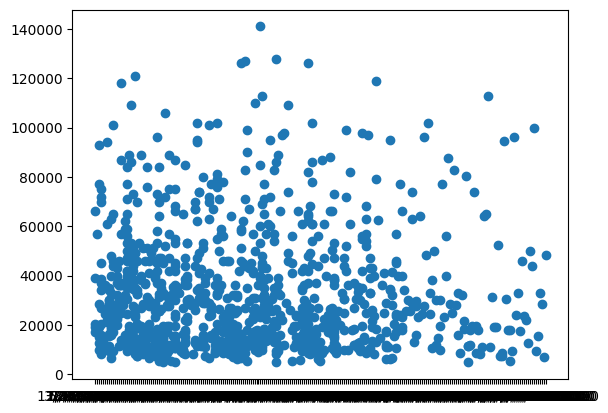

In [5]:
fig,ax = plt.subplots()
ax.scatter(df["saledate"][:1000],df["SalePrice"][:1000]);

In [6]:
df.saledate[:1000]

0      11/16/2006 0:00
1       3/26/2004 0:00
2       2/26/2004 0:00
3       5/19/2011 0:00
4       7/23/2009 0:00
            ...       
995     7/16/2009 0:00
996     6/14/2007 0:00
997     9/22/2005 0:00
998     7/28/2005 0:00
999     6/16/2011 0:00
Name: saledate, Length: 1000, dtype: object

<Axes: ylabel='Frequency'>

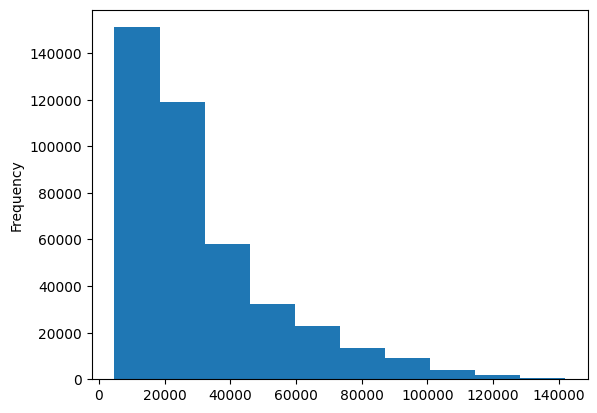

In [7]:
# it's better to use histogram
df.SalePrice.plot.hist()

### Parsing dates

When we work with time series data, we want to enrich the time & date component as much as possible.

we can do that by telling pandas which of our column has dates in it using the `parse_dates` parameter.



In [8]:
# Import data again but this time parse dates
df = pd.read_csv("data/bluebook-for-bulldozers/TrainAndValid.csv",
                low_memory=False,
                parse_dates=["saledate"])

In [9]:
df.saledate.dtype

dtype('<M8[ns]')

In [10]:
df.saledate[:1000]

0     2006-11-16
1     2004-03-26
2     2004-02-26
3     2011-05-19
4     2009-07-23
         ...    
995   2009-07-16
996   2007-06-14
997   2005-09-22
998   2005-07-28
999   2011-06-16
Name: saledate, Length: 1000, dtype: datetime64[ns]

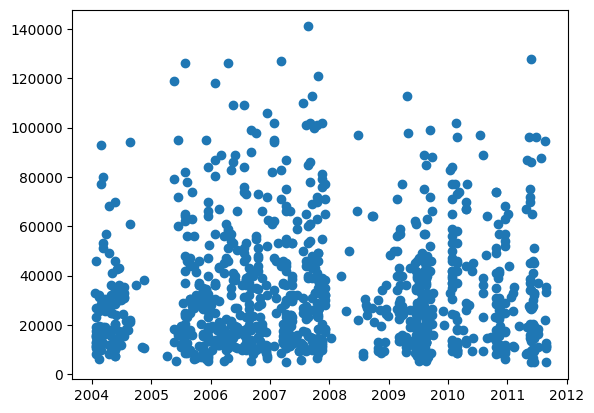

In [11]:
fig,ax = plt.subplots()
ax.scatter(df["saledate"][:1000],df["SalePrice"][:1000]);

In [12]:
# Now the above plot is better than previous because now it is doing 
# yearwise because we parse dates 

<h1 style="color:red">lec 180:-Exploring Our Data 2</h1>

In [13]:
df.head().T

0  \
SalesID                                                    1139246   
SalePrice                                                  66000.0   
MachineID                                                   999089   
ModelID                                                       3157   
datasource                                                     121   
auctioneerID                                                   3.0   
YearMade                                                      2004   
MachineHoursCurrentMeter                                      68.0   
UsageBand                                                      Low   
saledate                                       2006-11-16 00:00:00   
fiModelDesc                                                   521D   
fiBaseModel                                                    521   
fiSecondaryDesc                                                  D   
fiModelSeries                                                  NaN   
fiModelDescriptor                                              NaN   
ProductSize                                                    NaN   
fiProductClassDesc        Wheel Loader - 110.0 to 120.0 Horsepower   
state                                                      Alabama   
ProductGroup                                                    WL   
ProductGroupDesc                                      Wheel Loader   
Drive_System                                                   NaN   
Enclosure                                               EROPS w AC   
Forks                                          None or Unspecified   
Pad_Type                                                       NaN   
Ride_Control                                   None or Unspecified   
Stick                                                          NaN   
Transmission                                                   NaN   
Turbocharged                                                   NaN   
Blade_Extension                                                NaN   
Blade_Width                                                    NaN   
Enclosure_Type                                                 NaN   
Engine_Horsepower                                              NaN   
Hydraulics                                                 2 Valve   
Pushblock                                                      NaN   
Ripper                                                         NaN   
Scarifier                                                      NaN   
Tip_Control                                                    NaN   
Tire_Size                                      None or Unspecified   
Coupler                                        None or Unspecified   
Coupler_System                                                 NaN   
Grouser_Tracks                                                 NaN   
Hydraulics_Flow                                                NaN   
Track_Type                                                     NaN   
Undercarriage_Pad_Width                                        NaN   
Stick_Length                                                   NaN   
Thumb                                                          NaN   
Pattern_Changer                                                NaN   
Grouser_Type                                                   NaN   
Backhoe_Mounting                                               NaN   
Blade_Type                                                     NaN   
Travel_Controls                                                NaN   
Differential_Type                                         Standard   
Steering_Controls                                     Conventional   

                                                                 1  \
SalesID                                                    1139248   
SalePrice                                                  57000.0   
MachineID                                                   117657   
Mode

In [14]:
df.saledate.head(20)

0    2006-11-16
1    2004-03-26
2    2004-02-26
3    2011-05-19
4    2009-07-23
5    2008-12-18
6    2004-08-26
7    2005-11-17
8    2009-08-27
9    2007-08-09
10   2008-08-21
11   2006-08-24
12   2005-10-20
13   2006-01-26
14   2006-01-03
15   2006-11-16
16   2007-06-14
17   2010-01-28
18   2006-03-09
19   2005-11-17
Name: saledate, dtype: datetime64[ns]

<hr>

### Sort DataFrame by saledate

When working with time series data, it's a good idea to sort it by date.

In [15]:
# Sort DataFrame in date order
df.sort_values(by=["saledate"],inplace=True,ascending=True)
df.saledate.head(20)

205615   1989-01-17
274835   1989-01-31
141296   1989-01-31
212552   1989-01-31
62755    1989-01-31
54653    1989-01-31
81383    1989-01-31
204924   1989-01-31
135376   1989-01-31
113390   1989-01-31
113394   1989-01-31
116419   1989-01-31
32138    1989-01-31
127610   1989-01-31
76171    1989-01-31
127000   1989-01-31
128130   1989-01-31
127626   1989-01-31
55455    1989-01-31
55454    1989-01-31
Name: saledate, dtype: datetime64[ns]

### Make a copy of the original DataFrame

We make a copy of the original dataframe so when we manipulate the copy, we've still got our original data.

In [16]:
# Make a copy
df_tmp = df.copy()

In [17]:
df_tmp.saledate.head(20)

205615   1989-01-17
274835   1989-01-31
141296   1989-01-31
212552   1989-01-31
62755    1989-01-31
54653    1989-01-31
81383    1989-01-31
204924   1989-01-31
135376   1989-01-31
113390   1989-01-31
113394   1989-01-31
116419   1989-01-31
32138    1989-01-31
127610   1989-01-31
76171    1989-01-31
127000   1989-01-31
128130   1989-01-31
127626   1989-01-31
55455    1989-01-31
55454    1989-01-31
Name: saledate, dtype: datetime64[ns]

<h1 style="color:red">lec 181:-Feature Engineering</h1>

### Add datetime parameters for `saledate` column

In [18]:
df_tmp[:1].saledate.dt

In [19]:
print(df_tmp[:1].saledate.dt.day)
print(df_tmp[:1].saledate.dt.month)
print(df_tmp[:1].saledate.dt.year)
print(df_tmp[:1].saledate.dt.time)

205615    17
Name: saledate, dtype: int32
205615    1
Name: saledate, dtype: int32
205615    1989
Name: saledate, dtype: int32
205615    00:00:00
Name: saledate, dtype: object


In [20]:
df_tmp['saleYear'] = df_tmp.saledate.dt.year # for year = year , for datetime object = dt
df_tmp['saleMonth'] = df_tmp.saledate.dt.month
df_tmp['saleDay'] = df_tmp.saledate.dt.day
df_tmp['saleDayOfWeek']= df_tmp.saledate.dt.dayofweek
df_tmp["saleDayOfYear"] = df_tmp.saledate.dt.dayofyear

In [23]:
df_tmp.head().T

205615  \
SalesID                                                             1646770   
SalePrice                                                            9500.0   
MachineID                                                           1126363   
ModelID                                                                8434   
datasource                                                              132   
auctioneerID                                                           18.0   
YearMade                                                               1974   
MachineHoursCurrentMeter                                                NaN   
UsageBand                                                               NaN   
saledate                                                1989-01-17 00:00:00   
fiModelDesc                                                            TD20   
fiBaseModel                                                            TD20   
fiSecondaryDesc                                                         NaN   
fiModelSeries                                                           NaN   
fiModelDescriptor                                                       NaN   
ProductSize                                                          Medium   
fiProductClassDesc        Track Type Tractor, Dozer - 105.0 to 130.0 Hor...   
state                                                                 Texas   
ProductGroup                                                            TTT   
ProductGroupDesc                                        Track Type Tractors   
Drive_System                                                            NaN   
Enclosure                                                             OROPS   
Forks                                                                   NaN   
Pad_Type                                                                NaN   
Ride_Control                                                            NaN   
Stick                                                                   NaN   
Transmission                                                   Direct Drive   
Turbocharged                                                            NaN   
Blade_Extension                                                         NaN   
Blade_Width                                                             NaN   
Enclosure_Type                                                          NaN   
Engine_Horsepower                                                       NaN   
Hydraulics                                                          2 Valve   
Pushblock                                                               NaN   
Ripper                                                  None or Unspecified   
Scarifier                                                               NaN   
Tip_Control                                                             NaN   
Tire_Size                                                               NaN   
Coupler                                                                 NaN   
Coupler_System                                                          NaN   
Grouser_Tracks                                                          NaN   
Hydraulics_Flow                                                         NaN   
Track_Type                                                              NaN   
Undercarriage_Pad_Width                                                 NaN   
Stick_Length                                                            NaN   
Thumb                                                                   NaN   
Pattern_Changer                                                         NaN   
Grouser_Type                                                            NaN   
Backhoe_Mounting                                        None or Unspecified   
Blade_Type                                                         Straight   
Travel_Controls                         

In [24]:
# Now we've enriched our DataFrame with date time features, we can remove saledate
df_tmp.drop("saledate",axis=1,inplace=True)

In [25]:
df_tmp.head()

SalesID  SalePrice  MachineID  ModelID  datasource  auctioneerID  \
205615  1646770     9500.0    1126363     8434         132          18.0   
274835  1821514    14000.0    1194089    10150         132          99.0   
141296  1505138    50000.0    1473654     4139         132          99.0   
212552  1671174    16000.0    1327630     8591         132          99.0   
62755   1329056    22000.0    1336053     4089         132          99.0   

        YearMade  MachineHoursCurrentMeter UsageBand fiModelDesc  ...  \
205615      1974                       NaN       NaN        TD20  ...   
274835      1980                       NaN       NaN         A66  ...   
141296      1978                       NaN       NaN         D7G  ...   
212552      1980                       NaN       NaN         A62  ...   
62755       1984                       NaN       NaN         D3B  ...   

           Backhoe_Mounting Blade_Type      Travel_Controls Differential_Type  \
205615  None or Unspecified   Straight  None or Unspecified               NaN   
274835                  NaN        NaN                  NaN          Standard   
141296  None or Unspecified   Straight  None or Unspecified               NaN   
212552                  NaN        NaN                  NaN          Standard   
62755   None or Unspecified        PAT                Lever               NaN   

       Steering_Controls saleYear saleMonth saleDay saleDayOfWeek  \
205615               NaN     1989         1      17             1   
274835      Conventional     1989         1      31             1   
141296               NaN     1989         1      31             1   
212552      Conventional     1989         1      31             1   
62755                NaN     1989         1      31             1   

       saleDayOfYear  
205615            17  
274835            31  
141296            31  
212552            31  
62755             31  

[5 rows x 57 columns]

In [26]:
# check the values of different columns
df_tmp.state.value_counts()

state
Florida           67320
Texas             53110
California        29761
Washington        16222
Georgia           14633
Maryland          13322
Mississippi       13240
Ohio              12369
Illinois          11540
Colorado          11529
New Jersey        11156
North Carolina    10636
Tennessee         10298
Alabama           10292
Pennsylvania      10234
South Carolina     9951
Arizona            9364
New York           8639
Connecticut        8276
Minnesota          7885
Missouri           7178
Nevada             6932
Louisiana          6627
Kentucky           5351
Maine              5096
Indiana            4124
Arkansas           3933
New Mexico         3631
Utah               3046
Unspecified        2801
Wisconsin          2745
New Hampshire      2738
Virginia           2353
Idaho              2025
Oregon             1911
Michigan           1831
Wyoming            1672
Iowa               1336
Montana            1336
Oklahoma           1326
Nebraska            866
West Virgi

## 5. Modeling

We've done enough EDA (we could always do more) but let's start to do some model-driven EDA.

In [27]:
# Let's build a machine learning model
from sklearn.ensemble import RandomForestRegressor

model = RandomForestRegressor(n_jobs=-1, # very lengthy dataset we might use all cores of cpu
                             random_state=42)

model.fit(df_tmp.drop("SalePrice",axis=1),df_tmp.SalePrice)

ValueError: could not convert string to float: 'Low'

In [28]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 412698 entries, 205615 to 409203
Data columns (total 53 columns):
 #   Column                    Non-Null Count   Dtype         
---  ------                    --------------   -----         
 0   SalesID                   412698 non-null  int64         
 1   SalePrice                 412698 non-null  float64       
 2   MachineID                 412698 non-null  int64         
 3   ModelID                   412698 non-null  int64         
 4   datasource                412698 non-null  int64         
 5   auctioneerID              392562 non-null  float64       
 6   YearMade                  412698 non-null  int64         
 7   MachineHoursCurrentMeter  147504 non-null  float64       
 8   UsageBand                 73670 non-null   object        
 9   saledate                  412698 non-null  datetime64[ns]
 10  fiModelDesc               412698 non-null  object        
 11  fiBaseModel               412698 non-null  object        
 12  fi

In [30]:
df_tmp["UsageBand"].dtype # for check warnings

dtype('O')

In [32]:
df_tmp.isna().sum() # let's see missing values

SalesID                          0
SalePrice                        0
MachineID                        0
ModelID                          0
datasource                       0
auctioneerID                 20136
YearMade                         0
MachineHoursCurrentMeter    265194
UsageBand                   339028
fiModelDesc                      0
fiBaseModel                      0
fiSecondaryDesc             140727
fiModelSeries               354031
fiModelDescriptor           337882
ProductSize                 216605
fiProductClassDesc               0
state                            0
ProductGroup                     0
ProductGroupDesc                 0
Drive_System                305611
Enclosure                      334
Forks                       214983
Pad_Type                    331602
Ride_Control                259970
Stick                       331602
Transmission                224691
Turbocharged                331602
Blade_Extension             386715
Blade_Width         

<h1 style="color:red">lec 182:-Turning Data Into Numbers</h1>

### Convert string into categories

One way we can turn all of our data into numbers by converting them into pandas categories

we can check the different datatypes compatible with pandas here:- https://pandas.pydata.org/docs/reference/api/pandas.api.types.is_object_dtype.html

In [33]:
pd.api.types.is_string_dtype(df_tmp["UsageBand"])

False

# we're going to do the above thing with all columns

In [37]:
# Find the columns which contain strings
for label, content in df_tmp.items():
    if pd.api.types.is_string_dtype(content):
        print(label)

fiModelDesc
fiBaseModel
fiProductClassDesc
state
ProductGroup
ProductGroupDesc


### How to change datatypes of column in pandas - search on google

In [ ]:
# This will turn all of the string value into category values
# for label, content in df_tmp.items():
#     if pd.api.types.is_string_dtype(content):
#         df_tmp[label] = content.astype("category").cat.as_ordered()

In [41]:
# we have done this because of null values python treat them as object

string_cols_any = [col for col in df_tmp.columns if df_tmp[col].apply(lambda x: isinstance(x, str)).any()]
print(len(string_cols_any), "columns contain at least one str value")
print(string_cols_any)


44 columns contain at least one str value
['UsageBand', 'fiModelDesc', 'fiBaseModel', 'fiSecondaryDesc', 'fiModelSeries', 'fiModelDescriptor', 'ProductSize', 'fiProductClassDesc', 'state', 'ProductGroup', 'ProductGroupDesc', 'Drive_System', 'Enclosure', 'Forks', 'Pad_Type', 'Ride_Control', 'Stick', 'Transmission', 'Turbocharged', 'Blade_Extension', 'Blade_Width', 'Enclosure_Type', 'Engine_Horsepower', 'Hydraulics', 'Pushblock', 'Ripper', 'Scarifier', 'Tip_Control', 'Tire_Size', 'Coupler', 'Coupler_System', 'Grouser_Tracks', 'Hydraulics_Flow', 'Track_Type', 'Undercarriage_Pad_Width', 'Stick_Length', 'Thumb', 'Pattern_Changer', 'Grouser_Type', 'Backhoe_Mounting', 'Blade_Type', 'Travel_Controls', 'Differential_Type', 'Steering_Controls']


In [43]:
for col in string_cols_any:
    df_tmp[col] = df_tmp[col].astype("category").cat.as_ordered()

In [44]:
df_tmp.info()

<class 'pandas.core.frame.DataFrame'>
Index: 412698 entries, 205615 to 409203
Data columns (total 57 columns):
 #   Column                    Non-Null Count   Dtype   
---  ------                    --------------   -----   
 0   SalesID                   412698 non-null  int64   
 1   SalePrice                 412698 non-null  float64 
 2   MachineID                 412698 non-null  int64   
 3   ModelID                   412698 non-null  int64   
 4   datasource                412698 non-null  int64   
 5   auctioneerID              392562 non-null  float64 
 6   YearMade                  412698 non-null  int64   
 7   MachineHoursCurrentMeter  147504 non-null  float64 
 8   UsageBand                 73670 non-null   category
 9   fiModelDesc               412698 non-null  category
 10  fiBaseModel               412698 non-null  category
 11  fiSecondaryDesc           271971 non-null  category
 12  fiModelSeries             58667 non-null   category
 13  fiModelDescriptor         748

In [45]:
df_tmp.state.cat.categories

Index(['Alabama', 'Alaska', 'Arizona', 'Arkansas', 'California', 'Colorado',
       'Connecticut', 'Delaware', 'Florida', 'Georgia', 'Hawaii', 'Idaho',
       'Illinois', 'Indiana', 'Iowa', 'Kansas', 'Kentucky', 'Louisiana',
       'Maine', 'Maryland', 'Massachusetts', 'Michigan', 'Minnesota',
       'Mississippi', 'Missouri', 'Montana', 'Nebraska', 'Nevada',
       'New Hampshire', 'New Jersey', 'New Mexico', 'New York',
       'North Carolina', 'North Dakota', 'Ohio', 'Oklahoma', 'Oregon',
       'Pennsylvania', 'Puerto Rico', 'Rhode Island', 'South Carolina',
       'South Dakota', 'Tennessee', 'Texas', 'Unspecified', 'Utah', 'Vermont',
       'Virginia', 'Washington', 'Washington DC', 'West Virginia', 'Wisconsin',
       'Wyoming'],
      dtype='object')

In [46]:
# like we access datetime by dt now we are accessing categories as cat

df_tmp.state.cat.codes

205615    43
274835     8
141296     8
212552     8
62755      8
          ..
410879     4
412476     4
411927     4
407124     4
409203     4
Length: 412698, dtype: int8

Thanks to pandas categories we now have a way to access all of our data in the form of numbers

But we still have bunch of missing data...

In [47]:
# Check missing data
df_tmp.isnull().sum()/len(df_tmp)

SalesID                     0.000000
SalePrice                   0.000000
MachineID                   0.000000
ModelID                     0.000000
datasource                  0.000000
auctioneerID                0.048791
YearMade                    0.000000
MachineHoursCurrentMeter    0.642586
UsageBand                   0.821492
fiModelDesc                 0.000000
fiBaseModel                 0.000000
fiSecondaryDesc             0.340993
fiModelSeries               0.857845
fiModelDescriptor           0.818715
ProductSize                 0.524851
fiProductClassDesc          0.000000
state                       0.000000
ProductGroup                0.000000
ProductGroupDesc            0.000000
Drive_System                0.740520
Enclosure                   0.000809
Forks                       0.520921
Pad_Type                    0.803498
Ride_Control                0.629928
Stick                       0.803498
Transmission                0.544444
Turbocharged                0.803498
B

### Save preprocessed data

In [48]:
# Export current tmp dataframe
df_tmp.to_csv("data/bluebook-for-bulldozers/train_tmp.csv",
             index = False)

In [50]:
# Import preprocessed data
df_tmp = pd.read_csv("data/bluebook-for-bulldozers/train_tmp.csv",
             low_memory=False)
df_tmp.head().T

0  \
SalesID                                                             1646770   
SalePrice                                                            9500.0   
MachineID                                                           1126363   
ModelID                                                                8434   
datasource                                                              132   
auctioneerID                                                           18.0   
YearMade                                                               1974   
MachineHoursCurrentMeter                                                NaN   
UsageBand                                                               NaN   
fiModelDesc                                                            TD20   
fiBaseModel                                                            TD20   
fiSecondaryDesc                                                         NaN   
fiModelSeries                                                           NaN   
fiModelDescriptor                                                       NaN   
ProductSize                                                          Medium   
fiProductClassDesc        Track Type Tractor, Dozer - 105.0 to 130.0 Hor...   
state                                                                 Texas   
ProductGroup                                                            TTT   
ProductGroupDesc                                        Track Type Tractors   
Drive_System                                                            NaN   
Enclosure                                                             OROPS   
Forks                                                                   NaN   
Pad_Type                                                                NaN   
Ride_Control                                                            NaN   
Stick                                                                   NaN   
Transmission                                                   Direct Drive   
Turbocharged                                                            NaN   
Blade_Extension                                                         NaN   
Blade_Width                                                             NaN   
Enclosure_Type                                                          NaN   
Engine_Horsepower                                                       NaN   
Hydraulics                                                          2 Valve   
Pushblock                                                               NaN   
Ripper                                                  None or Unspecified   
Scarifier                                                               NaN   
Tip_Control                                                             NaN   
Tire_Size                                                               NaN   
Coupler                                                                 NaN   
Coupler_System                                                          NaN   
Grouser_Tracks                                                          NaN   
Hydraulics_Flow                                                         NaN   
Track_Type                                                              NaN   
Undercarriage_Pad_Width                                                 NaN   
Stick_Length                                                            NaN   
Thumb                                                                   NaN   
Pattern_Changer                                                         NaN   
Grouser_Type                                                            NaN   
Backhoe_Mounting                                        None or Unspecified   
Blade_Type                                                         Straight   
Travel_Controls                                         None or Unspecified   
Differential_Type                            

<h1 style="color:red">lec 183:-Filling Missing Numerical Values</h1>

### Fill Missing Values

#### Fill numeric missing values first

In [52]:
for label, content in df_tmp.items():
    if pd.api.types.is_numeric_dtype(content):
        print(label)

SalesID
SalePrice
MachineID
ModelID
datasource
auctioneerID
YearMade
MachineHoursCurrentMeter
saleYear
saleMonth
saleDay
saleDayOfWeek
saleDayOfYear


In [53]:
df_tmp.ModelID

0          8434
1         10150
2          4139
3          8591
4          4089
          ...  
412693     5266
412694    19330
412695    17244
412696     3357
412697     4701
Name: ModelID, Length: 412698, dtype: int64

In [56]:
# Finding which one of those above numeric columns have missing values
for label,content in df_tmp.items():
    if pd.api.types.is_numeric_dtype(content):
        if pd.isnull(content).sum():
            print(label)

auctioneerID
MachineHoursCurrentMeter


In [57]:
# Fill numeric rows with median
for label,content in df_tmp.items():
    if pd.api.types.is_numeric_dtype(content):
        if pd.isnull(content).sum():
            # Add a binary column which tells us if the data was missing or not(optional)
            df_tmp[label+"_is_missing"] = pd.isnull(content)
            # Fill missing numeric values with median
            df_tmp[label] = content.fillna(content.median())

The median is better than the mean when your data has outliers or is skewed, because it shows a more "typical" or "middle" value, whereas the mean gets pulled significantly by extreme high or low numbers, making it less representative (like household income). The mean is great for symmetrical, normal data (like test scores), but the median provides a clearer picture of the center for skewed data (like salaries or house prices).  
* Why the Median Wins (In Certain Situations):

  * Resistant to Outliers: Extreme values (e.g., a billionaire in a group of average earners) heavily inflate the mean but barely affect the median, as it only cares about the middle value. 
  * Better for Skewed Data: Income, property values, and reaction times are often skewed. The median (e.g., $50,000 salary) gives a better sense of what most people earn than the mean (e.g., $200,000 average). 
  * Represents "Typical": It reflects the central point where half the data is above and half is below, offering a more intuitive "typical" value. 
* When the Mean is Better:
  * Symmetrical Data: For data that's evenly distributed (like a bell curve), the mean accurately represents the center and uses all data points in its calculation.
  * Predictive Modeling: If you need to use the total sum or for further mathematical operations, the mean is essential. 
* Simple Example:
  * * Salaries Data: $40k, $45k, $50k, $55k, $1M
    * Mean: ~$238k (inflated by the $1M)
    * Median: $50k (a much better representation of the typical salary) 
In short, choose the median for skewed data and outliers, and the mean for symmetrical data without extremes, depending on what truly represents the "center" for your analysis. 

In [58]:
# Demonstrate how median is more robust than mean
hundreds = np.full((1000,),100)
hundreds_billion = np.append(hundreds,1000000000)
np.mean(hundreds),np.mean(hundreds_billion),np.median(hundreds),np.median(hundreds_billion)

(np.float64(100.0),
 np.float64(999100.8991008991),
 np.float64(100.0),
 np.float64(100.0))

In [59]:
# Check if there's any null numeric values
for label,content in df_tmp.items():
    if pd.api.types.is_numeric_dtype(content) and pd.isnull(content).sum():
        print(label) # nott any thus it doesn't print

In [60]:
# Check to see how many examples were missing
df_tmp.auctioneerID_is_missing.value_counts() # we have filled 20136 values with median

auctioneerID_is_missing
False    392562
True      20136
Name: count, dtype: int64

<h1 style="color:red">lec 184:-Filling Missing Categorical Values</h1>

### Filling and turning categorical variables into numbers

In [62]:
# Check for columns which aren't numeric
for label, content in df_tmp.items():
    if not pd.api.types.is_numeric_dtype(content):
        print(label)

UsageBand
fiModelDesc
fiBaseModel
fiSecondaryDesc
fiModelSeries
fiModelDescriptor
ProductSize
fiProductClassDesc
state
ProductGroup
ProductGroupDesc
Drive_System
Enclosure
Forks
Pad_Type
Ride_Control
Stick
Transmission
Turbocharged
Blade_Extension
Blade_Width
Enclosure_Type
Engine_Horsepower
Hydraulics
Pushblock
Ripper
Scarifier
Tip_Control
Tire_Size
Coupler
Coupler_System
Grouser_Tracks
Hydraulics_Flow
Track_Type
Undercarriage_Pad_Width
Stick_Length
Thumb
Pattern_Changer
Grouser_Type
Backhoe_Mounting
Blade_Type
Travel_Controls
Differential_Type
Steering_Controls


In [63]:
pd.Categorical(df_tmp["state"])

['Texas', 'Florida', 'Florida', 'Florida', 'Florida', ..., 'California', 'California', 'California', 'California', 'California']
Length: 412698
Categories (53, object): ['Alabama', 'Alaska', 'Arizona', 'Arkansas', ..., 'Washington DC', 'West Virginia', 'Wisconsin', 'Wyoming']

In [64]:
pd.Categorical(df_tmp["state"]).dtype

CategoricalDtype(categories=['Alabama', 'Alaska', 'Arizona', 'Arkansas', 'California',
                  'Colorado', 'Connecticut', 'Delaware', 'Florida', 'Georgia',
                  'Hawaii', 'Idaho', 'Illinois', 'Indiana', 'Iowa', 'Kansas',
                  'Kentucky', 'Louisiana', 'Maine', 'Maryland',
                  'Massachusetts', 'Michigan', 'Minnesota', 'Mississippi',
                  'Missouri', 'Montana', 'Nebraska', 'Nevada', 'New Hampshire',
                  'New Jersey', 'New Mexico', 'New York', 'North Carolina',
                  'North Dakota', 'Ohio', 'Oklahoma', 'Oregon', 'Pennsylvania',
                  'Puerto Rico', 'Rhode Island', 'South Carolina',
                  'South Dakota', 'Tennessee', 'Texas', 'Unspecified', 'Utah',
                  'Vermont', 'Virginia', 'Washington', 'Washington DC',
                  'West Virginia', 'Wisconsin', 'Wyoming'],
, ordered=False, categories_dtype=object)

In [65]:
pd.Categorical(df_tmp["state"]).codes

array([43,  8,  8, ...,  4,  4,  4], shape=(412698,), dtype=int8)

In [66]:
# Turn categorical variables into numbers and fill missing
for label,content in df_tmp.items():
    if not pd.api.types.is_numeric_dtype(content):
        # Add binary column to indicate whether sample had missing value
        df_tmp[label+"_is_missing"] = pd.isnull(content)
        # Turn categories into numbers and add +1
        df_tmp[label] = pd.Categorical(content).codes +1 
        # here +1 because if some category is missing the pandas automatically
        # assign -1 code to that but we don't want that that's why +1

In [67]:
df_tmp.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 412698 entries, 0 to 412697
Columns: 103 entries, SalesID to Steering_Controls_is_missing
dtypes: bool(46), float64(3), int16(4), int64(10), int8(40)
memory usage: 77.9 MB


In [68]:
df_tmp.head().T

0        1        2        3        4
SalesID                       1646770  1821514  1505138  1671174  1329056
SalePrice                      9500.0  14000.0  50000.0  16000.0  22000.0
MachineID                     1126363  1194089  1473654  1327630  1336053
ModelID                          8434    10150     4139     8591     4089
datasource                        132      132      132      132      132
...                               ...      ...      ...      ...      ...
Backhoe_Mounting_is_missing     False     True    False     True    False
Blade_Type_is_missing           False     True    False     True    False
Travel_Controls_is_missing      False     True    False     True    False
Differential_Type_is_missing     True    False     True    False     True
Steering_Controls_is_missing     True    False     True    False     True

[103 rows x 5 columns]

In [69]:
df_tmp.isna().sum()

SalesID                         0
SalePrice                       0
MachineID                       0
ModelID                         0
datasource                      0
                               ..
Backhoe_Mounting_is_missing     0
Blade_Type_is_missing           0
Travel_Controls_is_missing      0
Differential_Type_is_missing    0
Steering_Controls_is_missing    0
Length: 103, dtype: int64

<h1 style="color:red">lec 185:-Fitting A Machine Learning Model</h1>

Now that all of data is numeric as well as our dataframe has no missing values , we should be able to build a machine learning model.

In [70]:
df_tmp.head()

SalesID  SalePrice  MachineID  ModelID  datasource  auctioneerID  YearMade  \
0  1646770     9500.0    1126363     8434         132          18.0      1974   
1  1821514    14000.0    1194089    10150         132          99.0      1980   
2  1505138    50000.0    1473654     4139         132          99.0      1978   
3  1671174    16000.0    1327630     8591         132          99.0      1980   
4  1329056    22000.0    1336053     4089         132          99.0      1984   

   MachineHoursCurrentMeter  UsageBand  fiModelDesc  ...  \
0                       0.0          0         4593  ...   
1                       0.0          0         1820  ...   
2                       0.0          0         2348  ...   
3                       0.0          0         1819  ...   
4                       0.0          0         2119  ...   

   Undercarriage_Pad_Width_is_missing  Stick_Length_is_missing  \
0                                True                     True   
1                                True                     True   
2                                True                     True   
3                                True                     True   
4                                True                     True   

   Thumb_is_missing  Pattern_Changer_is_missing  Grouser_Type_is_missing  \
0              True                        True                     True   
1              True                        True                     True   
2              True                        True                     True   
3              True                        True                     True   
4              True                        True                     True   

   Backhoe_Mounting_is_missing  Blade_Type_is_missing  \
0                        False                  False   
1                         True                   True   
2                        False                  False   
3                         True                   True   
4                        False                  False   

   Travel_Controls_is_missing  Differential_Type_is_missing  \
0                       False                          True   
1                        True                         False   
2                       False                          True   
3                        True                         False   
4                       False                          True   

   Steering_Controls_is_missing  
0                          True  
1                         False  
2                          True  
3                         False  
4                          True  

[5 rows x 103 columns]

In [71]:
len(df_tmp)

412698

In [72]:
%%time
# Instantiate model
model = RandomForestRegressor(n_jobs=-1,
                             random_state=42)

# Fit the model
model.fit(df_tmp.drop("SalePrice",axis = 1),df_tmp.SalePrice)

CPU times: total: 30min 30s
Wall time: 4min 12s


RandomForestRegressor(n_jobs=-1, random_state=42)

In [73]:
# in our mind we must have how to reduce the time without compromising model


In [74]:
%%time
# Score the model
model.score(df_tmp.drop("SalePrice",axis = 1),df_tmp.SalePrice)

CPU times: total: 31.2 s
Wall time: 4.66 s


0.9875468079970562

In [75]:
# why R2 is bad why we can't depend only upon this value
"""
R² (Coefficient of Determination)
Proportion of variance explained by model.
1 = perfect. 0 = predicts mean. Negative = worse than mean.
"""

'\nR² (Coefficient of Determination)\nProportion of variance explained by model.\n1 = perfect. 0 = predicts mean. Negative = worse than mean.\n'

<p>In the previous few videos we worked on filling the missing data in the training and validation data before splitting it into training and validation sets using the following code:</p><pre class="prettyprint linenums"># Split data into training and validation
df_val = df_tmp[df_tmp.saleYear == 2012]
df_train = df_tmp[df_tmp.saleYear != 2012]</pre><p>The code worked but how might this interfere with our model?</p><p>Remember the goal of machine learning: use the past to predict the future.</p><p>So if our validation set is supposed to be representative of the future and we’re filling our training data using information from the validation set, what might this mean for our model?</p><p>The challenge here comes in two parts.</p><ol><li><p>What does it mean if we fill our training data with information from the future (validation set)?</p></li><li><p>How might you implement a fix to the current way things are being done in the project?</p></li></ol><p>If you need a hint, remember some takeaways from a previous lecture:</p><ul><li><p>Encode/transform all <strong>categorical variables</strong> of your data (on the entire dataset, this ensures categorical variables are encoded the same across training/test sets, if you can't do this, make sure the training and test sets have the same column names).</p></li><li><p>Split your data (into train/test).</p></li><li><p>Fill the training set and test set <strong>numerical values</strong> separately.</p><ul><li><p>Don’t use numerical data from the future (test set) to fill data from the past (training set).</p></li></ul></li></ul><p>Keep these things in mind when we create a data preprocessing function in a few videos time, they'll help you answer the question which gets raised then too.</p>

<hr>
Here is the clear explanation of what your teacher is saying, and the answers to the questions.

---

## What your teacher is pointing out

You have code like:

```python
df_val = df_tmp[df_tmp.saleYear == 2012]
df_train = df_tmp[df_tmp.saleYear != 2012]
```

But *before this split*, you filled missing values on the **entire df_tmp**.

This means:

* When you filled missing values, the **training data** was filled using **information from validation data**.
* Validation data represents **the future** (year 2012).
* Training data represents **the past** (all years before 2012).

So your model is secretly using “future information” while training.

This creates **data leakage**.

---

## What exactly is data leakage here?

If you calculate things like mean, median, or any statistical measure using the **whole dataset first**, then:

* The imputed values in training data are influenced by validation data.
* Your model indirectly “sees” validation set patterns before evaluation.

Result:
Your model will perform unrealistically well on validation and won’t generalize to real unseen data.

---

## Teacher’s Question 1

### What does it mean if we fill our training data with information from the *future* (validation set)?

**Answer:**
It causes **data leakage**, meaning the model learns patterns from the validation data (future data). This gives a fake increase in model performance and breaks the rule of machine learning: *use past to predict future*.

---

## Teacher’s Question 2

### How to fix the current way of doing things?

Fix is simple:

1. **Split the dataset first** (train vs validation)
2. **Only fit the imputer (mean, median, mode) on the training set**
3. **Apply that imputation model to the validation set**

Correct approach:

```python
# Step 1: Split FIRST
df_val = df_tmp[df_tmp.saleYear == 2012]
df_train = df_tmp[df_tmp.saleYear != 2012]

# Step 2: Fit imputers ONLY on training data
train_median = df_train[numerical_cols].median()

# Step 3: Apply SAME statistics to both sets
df_train[numerical_cols] = df_train[numerical_cols].fillna(train_median)
df_val[numerical_cols] = df_val[numerical_cols].fillna(train_median)
```

This ensures:

* No future information is leaked.
* Validation set truly simulates new unseen data.

---

## Summary

Your teacher is teaching **data leakage prevention**. The mistake in the code is filling missing data **before** splitting, which mixes training and validation information. Fix it by splitting first, then imputing each split correctly using training statistics only.

If you want, I can rewrite your preprocessing pipeline correctly.


<h1 style="color:red">lec 186:-Splitting Data</h1>

**Question:** Why doesn't the above metric hold water? (Why isn't the metric reliable)

### Splitting data into train/validation sets

In [76]:
df_tmp.saleYear

0         1989
1         1989
2         1989
3         1989
4         1989
          ... 
412693    2012
412694    2012
412695    2012
412696    2012
412697    2012
Name: saleYear, Length: 412698, dtype: int64

In [77]:
df_tmp.saleYear.value_counts()

saleYear
2009    43849
2008    39767
2011    35197
2010    33390
2007    32208
2006    21685
2005    20463
2004    19879
2001    17594
2000    17415
2002    17246
2003    15254
1998    13046
1999    12793
2012    11573
1997     9785
1996     8829
1995     8530
1994     7929
1993     6303
1992     5519
1991     5109
1989     4806
1990     4529
Name: count, dtype: int64

In [78]:
# Split data into training and validation
df_val = df_tmp[df_tmp.saleYear==2012]
df_train = df_tmp[df_tmp.saleYear!=2012]

len(df_val), len(df_train)

(11573, 401125)

In [79]:
# Split data into X & y
X_train , y_train = df_train.drop("SalePrice",axis=1), df_train.SalePrice
X_valid , y_valid = df_val.drop("SalePrice",axis=1), df_val.SalePrice


X_train.shape, y_train.shape, X_valid.shape,   y_valid.shape # to check whether these train valid sets comparable or not

((401125, 102), (401125,), (11573, 102), (11573,))

<h1 style="color:red">lec 188:-Custom Evaluation Function</h1>

### Building an evaluation function

In [86]:
# Create evaluation function (the competition uses RMSLE)
from sklearn.metrics import mean_squared_log_error, mean_absolute_error, r2_score

def rmsle(y_test,y_preds):
    """
    Calculates root mean squared log error between predictions and true labels.
    """
    return np.sqrt(mean_squared_log_error(y_test,y_preds))

# Create function to evaluate model on a different levels
def show_scores(model):
    train_preds = model.predict(X_train)
    val_preds = model.predict(X_valid)
    scores = {"Training MAE": mean_absolute_error(y_train,train_preds),
             "Valid MAE": mean_absolute_error(y_valid,val_preds),
             "Training RMSLE":rmsle(y_train,train_preds),
             "Valid RMSLE":rmsle(y_valid,val_preds),
             "Training R^2":r2_score(y_train,train_preds),
             "Valid R^2":r2_score(y_valid,val_preds)}
    return scores

<h1 style="color:red">lec 189:-Reducing Data</h1>

## Testing our model on a subset (to tune the hyperparameters)

In [81]:
# # This takes far too long... for experimenting
# %%time
# model = RanodmForestRegressor(n_jobs=-1,
#                              random_state=42)

# model.fit(X_train,y_train)

In [ ]:
# Change max_samples value
model = RandomForestRegressor(n_jobs=-1,
                             random_state=42,
                             max_samples=10000)

In [82]:
# if we do max_samples = default(X_train.shape[0]) then every n_estimators(default 100) have default samples
X_train.shape[0]*100

40112500

In [83]:
# Change max_samples value
model = RandomForestRegressor(n_jobs=-1,
                             random_state=42,
                             max_samples=10000)

In [84]:
%%time
# Cutting down on the max number of samples each estimator can see improves training time
model.fit(X_train,y_train)

CPU times: total: 57.4 s
Wall time: 8.01 s


RandomForestRegressor(max_samples=10000, n_jobs=-1, random_state=42)

In [87]:
show_scores(model)

{'Training MAE': 5561.298809224058,
 'Valid MAE': 7177.26365505919,
 'Training RMSLE': np.float64(0.25774537825697696),
 'Valid RMSLE': np.float64(0.29362638671089003),
 'Training R^2': 0.8606658995199188,
 'Valid R^2': 0.8320374995090507}

<h1 style="color:red">lec 190:-RandomizedSearchCV</h1>

Here’s a detailed breakdown of how `"auto"` used to work in **RandomForestRegressor** and what to replace it with now in different scenarios:

---

### 1️⃣ Original `"auto"` behavior:

* In **RandomForestRegressor**, `"auto"` **meant the same as `"sqrt"` for classification** in older versions, but for **regression**, it effectively used **all features** (`n_features`) at each split.
* In **RandomForestClassifier**, `"auto"` meant `max_features = sqrt(n_features)`.

---

### 2️⃣ Replacement options for `max_features` in `RandomForestRegressor`:

| Replacement       | Meaning / Behavior                                                   | When to use it                                                                   |
| ----------------- | -------------------------------------------------------------------- | -------------------------------------------------------------------------------- |
| `"sqrt"`          | Use √(n_features) features at each split                             | Default for classification, can work for regression if you want more randomness. |
| `"log2"`          | Use log2(n_features) features at each split                          | If dataset has **many features**, reduces computation and increases randomness.  |
| `None`            | Use all features at each split (same as old `"auto"` for regression) | If you want **maximum accuracy**, less randomness, but slower.                   |
| Float between 0–1 | Fraction of features (e.g., `0.5` → half of features)                | If you want a **tunable balance** between speed and accuracy.                    |
| Integer           | Exact number of features to consider at each split                   | When you want precise control over number of features per split.                 |

---

### 3️⃣ Practical recommendations:

* **Small feature set (<50 features):** `None` or `0.5` works fine.
* **Medium feature set (50–500 features):** `"sqrt"` or `0.5` for faster computation.
* **Very large feature set (>500 features):** `"log2"` or a float like `0.3`–`0.5` to reduce overfitting and speed up training.

---

If you want, I can rewrite your **RandomizedSearchCV grid** with **modern recommended values** that won’t throw deprecation warnings and will give efficient results. Do you want me to do that?


### Hyperparameter tuning with RandomizedSearchCV

In [90]:
%%time
from sklearn.model_selection import RandomizedSearchCV

# Different RandomForestRegressor hyperparameters
rf_grid ={"n_estimators":np.arange(10,100,10),
         "max_depth":[None,3,5,10],
         "min_samples_split":np.arange(2,20,2),
         "min_samples_leaf":np.arange(1,20,2),
         "max_features":[0.5,1,"sqrt","log2"],
         "max_samples":[10000]}

# Instantiate RandomizedSearchCV model
rs_model = RandomizedSearchCV(RandomForestRegressor(n_jobs=-1,
                                                   random_state=42),
                             param_distributions = rf_grid,
                             n_iter=2,
                             cv=5,
                             verbose=True)

# Fit the RandomizedSearchCV model
rs_model.fit(X_train,y_train)

Fitting 5 folds for each of 2 candidates, totalling 10 fits
CPU times: total: 35.5 s
Wall time: 9.88 s


RandomizedSearchCV(cv=5,
                   estimator=RandomForestRegressor(n_jobs=-1, random_state=42),
                   n_iter=2,
                   param_distributions={'max_depth': [None, 3, 5, 10],
                                        'max_features': [0.5, 1, 'sqrt',
                                                         'log2'],
                                        'max_samples': [10000],
                                        'min_samples_leaf': array([ 1,  3,  5,  7,  9, 11, 13, 15, 17, 19]),
                                        'min_samples_split': array([ 2,  4,  6,  8, 10, 12, 14, 16, 18]),
                                        'n_estimators': array([10, 20, 30, 40, 50, 60, 70, 80, 90])},
                   verbose=True)

In [91]:
# Find the best model hyperparameters
rs_model.best_params_

{'n_estimators': np.int64(70),
 'min_samples_split': np.int64(14),
 'min_samples_leaf': np.int64(3),
 'max_samples': 10000,
 'max_features': 'log2',
 'max_depth': 10}

In [92]:
# Evaluate the RandomizedSearch model
show_scores(rs_model)

{'Training MAE': 9705.498444601537,
 'Valid MAE': 11229.320295740197,
 'Training RMSLE': np.float64(0.42522420697265567),
 'Valid RMSLE': np.float64(0.44352778019399147),
 'Training R^2': 0.6353690583218755,
 'Valid R^2': 0.6439148691940488}

<h1 style="color:red">lec 191:-Improving Hyper parameters</h1>

### Train a model with the best hyperparameters

**Note:** These were found after 100 iterations of `RandomizedSearchCV`.

In [94]:
%%time

# Most ideal hyperparameters
ideal_model = RandomForestRegressor(n_estimators=40,
                                   min_samples_leaf=1,
                                   min_samples_split=14,
                                   max_features=0.5,
                                   n_jobs=-1,
                                   max_samples=None, # none means whole dataset
                                   random_state = 42) # so our results are reproducible 
# Fit the ideal model
ideal_model.fit(X_train,y_train)

CPU times: total: 5min 29s
Wall time: 46.1 s


RandomForestRegressor(max_features=0.5, min_samples_split=14, n_estimators=40,
                      n_jobs=-1)

In [95]:
# Scores for ideal model (trained on all the data)
show_scores(ideal_model)

{'Training MAE': 2952.6062823369675,
 'Valid MAE': 5955.4860347061485,
 'Training RMSLE': np.float64(0.14442251947467963),
 'Valid RMSLE': np.float64(0.24602007113036398),
 'Training R^2': 0.9589848595903925,
 'Valid R^2': 0.8820318762984503}

In [96]:
# Scores on rs_model (only trained on ~10,000 examples)
show_scores(rs_model)

{'Training MAE': 9705.498444601537,
 'Valid MAE': 11229.320295740197,
 'Training RMSLE': np.float64(0.42522420697265567),
 'Valid RMSLE': np.float64(0.4435277801939915),
 'Training R^2': 0.6353690583218755,
 'Valid R^2': 0.6439148691940488}

<h1 style="color:red">lec 192:-Preprocessing Our Data</h1>

### Make prediction on test data 

In [117]:
# Import the test data
df_test = pd.read_csv("data/bluebook-for-bulldozers/Test.csv",
                     low_memory=False,
                     parse_dates=["saledate"])
df_test.head()

SalesID  MachineID  ModelID  datasource  auctioneerID  YearMade  \
0  1227829    1006309     3168         121             3      1999   
1  1227844    1022817     7271         121             3      1000   
2  1227847    1031560    22805         121             3      2004   
3  1227848      56204     1269         121             3      2006   
4  1227863    1053887    22312         121             3      2005   

   MachineHoursCurrentMeter UsageBand   saledate fiModelDesc  ...  \
0                    3688.0       Low 2012-05-03        580G  ...   
1                   28555.0      High 2012-05-10         936  ...   
2                    6038.0    Medium 2012-05-10    EC210BLC  ...   
3                    8940.0      High 2012-05-10       330CL  ...   
4                    2286.0       Low 2012-05-10        650K  ...   

  Undercarriage_Pad_Width         Stick_Length   Thumb      Pattern_Changer  \
0                     NaN                  NaN     NaN                  NaN   
1                     NaN                  NaN     NaN                  NaN   
2     None or Unspecified                9' 6"  Manual  None or Unspecified   
3     None or Unspecified  None or Unspecified  Manual                  Yes   
4                     NaN                  NaN     NaN                  NaN   

  Grouser_Type     Backhoe_Mounting Blade_Type      Travel_Controls  \
0          NaN                  NaN        NaN                  NaN   
1          NaN                  NaN        NaN                  NaN   
2       Double                  NaN        NaN                  NaN   
3       Triple                  NaN        NaN                  NaN   
4          NaN  None or Unspecified        PAT  None or Unspecified   

  Differential_Type Steering_Controls  
0               NaN               NaN  
1          Standard      Conventional  
2               NaN               NaN  
3               NaN               NaN  
4               NaN               NaN  

[5 rows x 52 columns]

In [118]:
df_test["saledate"].dtype
# Should show: datetime64[ns]


dtype('<M8[ns]')

In [98]:
# Make predictions on the test dataset
# test_preds = ideal_model.predict(df_test) # we need preprocessing before

ValueError: The feature names should match those that were passed during fit.
Feature names unseen at fit time:
- saledate
Feature names seen at fit time, yet now missing:
- Backhoe_Mounting_is_missing
- Blade_Extension_is_missing
- Blade_Type_is_missing
- Blade_Width_is_missing
- Coupler_System_is_missing
- ...


In [100]:
df_test.isna().sum()

SalesID                         0
MachineID                       0
ModelID                         0
datasource                      0
auctioneerID                    0
YearMade                        0
MachineHoursCurrentMeter    10328
UsageBand                   10623
saledate                        0
fiModelDesc                     0
fiBaseModel                     0
fiSecondaryDesc              3975
fiModelSeries               10451
fiModelDescriptor            9433
ProductSize                  6409
fiProductClassDesc              0
state                           0
ProductGroup                    0
ProductGroupDesc                0
Drive_System                 9698
Enclosure                       2
Forks                        6149
Pad_Type                    10349
Ride_Control                 8216
Stick                       10349
Transmission                 7639
Turbocharged                10349
Blade_Extension             11806
Blade_Width                 11806
Enclosure_Type

In [101]:
df_test.columns

Index(['SalesID', 'MachineID', 'ModelID', 'datasource', 'auctioneerID',
       'YearMade', 'MachineHoursCurrentMeter', 'UsageBand', 'saledate',
       'fiModelDesc', 'fiBaseModel', 'fiSecondaryDesc', 'fiModelSeries',
       'fiModelDescriptor', 'ProductSize', 'fiProductClassDesc', 'state',
       'ProductGroup', 'ProductGroupDesc', 'Drive_System', 'Enclosure',
       'Forks', 'Pad_Type', 'Ride_Control', 'Stick', 'Transmission',
       'Turbocharged', 'Blade_Extension', 'Blade_Width', 'Enclosure_Type',
       'Engine_Horsepower', 'Hydraulics', 'Pushblock', 'Ripper', 'Scarifier',
       'Tip_Control', 'Tire_Size', 'Coupler', 'Coupler_System',
       'Grouser_Tracks', 'Hydraulics_Flow', 'Track_Type',
       'Undercarriage_Pad_Width', 'Stick_Length', 'Thumb', 'Pattern_Changer',
       'Grouser_Type', 'Backhoe_Mounting', 'Blade_Type', 'Travel_Controls',
       'Differential_Type', 'Steering_Controls'],
      dtype='object')

In [102]:
X_train.columns

Index(['SalesID', 'MachineID', 'ModelID', 'datasource', 'auctioneerID',
       'YearMade', 'MachineHoursCurrentMeter', 'UsageBand', 'fiModelDesc',
       'fiBaseModel',
       ...
       'Undercarriage_Pad_Width_is_missing', 'Stick_Length_is_missing',
       'Thumb_is_missing', 'Pattern_Changer_is_missing',
       'Grouser_Type_is_missing', 'Backhoe_Mounting_is_missing',
       'Blade_Type_is_missing', 'Travel_Controls_is_missing',
       'Differential_Type_is_missing', 'Steering_Controls_is_missing'],
      dtype='object', length=102)

The error you’re seeing actually has **two parts**. Let me break them down carefully.

---

### **1️⃣ Current Error in Your Code**

```python
ValueError: The feature names should match those that were passed during fit.
Feature names unseen at fit time:
- saledate
Feature names seen at fit time, yet now missing:
- Backhoe_Mounting_is_missing
- Blade_Extension_is_missing
...
```

**Meaning:**

* When you trained `ideal_model` on `X_train`, it had certain columns/features (like `Backhoe_Mounting_is_missing`, `Blade_Extension_is_missing`, etc.).
* Now, in `df_test`, the columns **do not match** the training data:

  * **Some new columns** are present (`saledate`).
  * **Some old columns** are missing (`Backhoe_Mounting_is_missing`, etc.).

**RandomForestRegressor cannot handle this** because it expects the **exact same feature names and order** as during training.

**Solution:**

* Ensure `df_test` has exactly the same columns as `X_train`, in the same order.
* If you created dummy variables (one-hot encoding) or missing indicators for training, do the same for the test set.

Example:

```python
df_test = df_test[X_train.columns]  # keep only training columns in same order
test_preds = ideal_model.predict(df_test)
```

---

### **2️⃣ "Cannot convert float to string"**

This is a **different type of error** you might encounter in preprocessing. It usually happens when:

* A column in your dataset contains **mixed types**: some values are strings and some are numbers (float).
* Functions like `RandomForestRegressor` or `pd.to_numeric()` cannot automatically convert strings to floats.

**Example:**

```python
import pandas as pd

df = pd.DataFrame({"col": [1.0, 2.5, "missing"]})
df["col"] = df["col"].astype(float)  # ❌ Error: cannot convert string "missing" to float
```

**Solution:**

* Replace or encode non-numeric values before training or predicting:

```python
df["col"] = pd.to_numeric(df["col"], errors="coerce")  # converts invalid strings to NaN
df["col"].fillna(0, inplace=True)  # optional: fill NaNs
```

---

In your case, focus **first on aligning `df_test` columns with `X_train`**. That’s the immediate reason for your prediction error.

I can give you a **ready-to-use snippet to make `df_test` exactly like `X_train`**, including dummy columns and missing indicators. Do you want me to do that?


### Preprocessing the data(getting the test dataset in the same format as our training dataset)

In [120]:
def preprocess_data(df):
    """
    Performs transformation on df and return transformed df.
    """
    df["saleYear"] = df.saledate.dt.year
    df["saleMonth"] = df["saledate"].dt.month
    df["saleDay"] = df["saledate"].dt.day
    df["saleDayOfWeek"] = df["saledate"].dt.dayofweek
    df["saleDayOfYear"] = df["saledate"].dt.dayofyear


    df.drop("saledate",axis=1,inplace=True)

    # Fill the numeric rows with median
    for label,content in df.items():
        if pd.api.types.is_numeric_dtype(content):
            if pd.isnull(content).sum():
                # Add a binary column which tells us if the data was missing or not(optional)
                df[label+"_is_missing"] = pd.isnull(content)
                # Fill missing numeric values with median
                df[label] = content.fillna(content.median())

        # Fill categorical missing data and turn categories into numbers
        if not pd.api.types.is_numeric_dtype(content):
            df[label+"_is_missing"] = pd.isnull(content)
            # We add +1 to the category code because pandas encode missing category with -1
            df[label] = pd.Categorical(content).codes+1

    return df

<h1 style="color:red">lec 193:-Making Predictions</h1>

In [121]:
# preprocess the test data
df_test = preprocess_data(df_test)
df_test.head()

SalesID  MachineID  ModelID  datasource  auctioneerID  YearMade  \
0  1227829    1006309     3168         121             3      1999   
1  1227844    1022817     7271         121             3      1000   
2  1227847    1031560    22805         121             3      2004   
3  1227848      56204     1269         121             3      2006   
4  1227863    1053887    22312         121             3      2005   

   MachineHoursCurrentMeter  UsageBand  fiModelDesc  fiBaseModel  ...  \
0                    3688.0          2          499          180  ...   
1                   28555.0          1          831          292  ...   
2                    6038.0          3         1177          404  ...   
3                    8940.0          1          287          113  ...   
4                    2286.0          2          566          196  ...   

   Undercarriage_Pad_Width_is_missing  Stick_Length_is_missing  \
0                                True                     True   
1                                True                     True   
2                               False                    False   
3                               False                    False   
4                                True                     True   

   Thumb_is_missing  Pattern_Changer_is_missing  Grouser_Type_is_missing  \
0              True                        True                     True   
1              True                        True                     True   
2             False                       False                    False   
3             False                       False                    False   
4              True                        True                     True   

   Backhoe_Mounting_is_missing  Blade_Type_is_missing  \
0                         True                   True   
1                         True                   True   
2                         True                   True   
3                         True                   True   
4                        False                  False   

   Travel_Controls_is_missing  Differential_Type_is_missing  \
0                        True                          True   
1                        True                         False   
2                        True                          True   
3                        True                          True   
4                       False                          True   

   Steering_Controls_is_missing  
0                          True  
1                         False  
2                          True  
3                          True  
4                          True  

[5 rows x 101 columns]

In [123]:
# Make predictions on updated test data
test_preds = ideal_model.predict(df_test)

ValueError: The feature names should match those that were passed during fit.
Feature names seen at fit time, yet now missing:
- auctioneerID_is_missing


In [124]:
# We can find how the columns differ using sets
set(X_train.columns) - set(df_test.columns)

{'auctioneerID_is_missing'}

In [125]:
# why {'auctioneerID_is_missing'} is not in df_test because there is all auctioneerID in df_test so we have to manually give all False values to {'auctioneerID_is_missing'} column
df_test["auctioneerID_is_missing"] = False
df_test.head()

SalesID  MachineID  ModelID  datasource  auctioneerID  YearMade  \
0  1227829    1006309     3168         121             3      1999   
1  1227844    1022817     7271         121             3      1000   
2  1227847    1031560    22805         121             3      2004   
3  1227848      56204     1269         121             3      2006   
4  1227863    1053887    22312         121             3      2005   

   MachineHoursCurrentMeter  UsageBand  fiModelDesc  fiBaseModel  ...  \
0                    3688.0          2          499          180  ...   
1                   28555.0          1          831          292  ...   
2                    6038.0          3         1177          404  ...   
3                    8940.0          1          287          113  ...   
4                    2286.0          2          566          196  ...   

   Stick_Length_is_missing  Thumb_is_missing  Pattern_Changer_is_missing  \
0                     True              True                        True   
1                     True              True                        True   
2                    False             False                       False   
3                    False             False                       False   
4                     True              True                        True   

   Grouser_Type_is_missing  Backhoe_Mounting_is_missing  \
0                     True                         True   
1                     True                         True   
2                    False                         True   
3                    False                         True   
4                     True                        False   

   Blade_Type_is_missing  Travel_Controls_is_missing  \
0                   True                        True   
1                   True                        True   
2                   True                        True   
3                   True                        True   
4                  False                       False   

   Differential_Type_is_missing  Steering_Controls_is_missing  \
0                          True                          True   
1                         False                         False   
2                          True                          True   
3                          True                          True   
4                          True                          True   

   auctioneerID_is_missing  
0                    False  
1                    False  
2                    False  
3                    False  
4                    False  

[5 rows x 102 columns]

This `ValueError` means your **test DataFrame (`df_test`) still doesn’t exactly match the training DataFrame (`X_train`)**—either in **column names** or **column order**. `RandomForestRegressor` requires the features to be identical to what it was trained on.

---

### **Steps to fix**

1. **Ensure all columns from training exist in test**:

```python
for col in X_train.columns:
    if col not in df_test.columns:
        # Add missing columns with default value 0
        df_test[col] = 0
```

2. **Ensure the columns are in the exact same order**:

```python
df_test = df_test[X_train.columns]
```

3. **Then make predictions**:

```python
test_preds = ideal_model.predict(df_test)
```

---

### **Why this works**

* RandomForestRegressor uses **feature positions** internally, not just names.
* Even if all columns exist but are **out of order**, you get this error.
* Adding missing columns and reordering ensures **column count, names, and order exactly match training**.

---

If you want, I can provide a **complete preprocessing snippet** that:

* Handles missing values
* Encodes categoricals
* Adds `_is_missing` columns
* Aligns test set to training set

so you can predict without any more feature mismatch errors.


In [127]:
df_test = df_test[X_train.columns]


Finally now our test dataFrame has the same features as our training dataframe, we can make predictions!

In [128]:
# Make predictions on the test data
test_preds = ideal_model.predict(df_test)

In [129]:
len(test_preds)

12457

In [130]:
test_preds

array([17857.48538197, 17968.28122845, 50982.07594101, ...,
       12467.43413046, 15851.86016295, 25844.74629022], shape=(12457,))

We've made some predictions but they're not in the same format Kaggle is asking for:
https://www.kaggle.com/c/bluebook-for-bulldozers/overview/evaluation

In [131]:
# Format predictions into the same format Kaggle is after
df_preds = pd.DataFrame()
df_preds["SalesID"] = df_test["SalesID"]
df_preds["SalesPrice"] = test_preds
df_preds

SalesID    SalesPrice
0      1227829  17857.485382
1      1227844  17968.281228
2      1227847  50982.075941
3      1227848  65433.590716
4      1227863  59333.328985
...        ...           ...
12452  6643171  40313.035885
12453  6643173  12157.562141
12454  6643184  12467.434130
12455  6643186  15851.860163
12456  6643196  25844.746290

[12457 rows x 2 columns]

In [132]:
# Export prediction data
df_preds.to_csv("data/bluebook-for-bulldozers/test-prediction.csv",index=False)

https://github.com/mrdbourke/zero-to-mastery-ml/blob/master/section-3-structured-data-projects/end-to-end-bluebook-bulldozer-price-regression.ipynb

<h1 style="color:red">lec 194:-Feature Importance</h1>

### Feature Importance

Feature importance seeks to figure out which different attributes of the data were most important when it comes to predicting the **target variable** (SalePrice)

In [134]:
# Find feature importance of our best model
ideal_model.feature_importances_

array([3.25589497e-02, 1.95882551e-02, 4.18895100e-02, 1.68070891e-03,
       3.35120167e-03, 2.00204160e-01, 3.24438150e-03, 9.93961060e-04,
       4.22630914e-02, 5.42553913e-02, 6.91103337e-02, 4.85486943e-03,
       1.37966273e-02, 1.53362038e-01, 3.93183275e-02, 5.94423658e-03,
       4.62927099e-03, 3.18786719e-03, 3.31446556e-03, 6.51685577e-02,
       5.73504810e-04, 4.95654956e-05, 8.07555302e-04, 1.87444693e-04,
       1.11807966e-03, 2.82072893e-04, 2.21650524e-03, 6.32168510e-03,
       2.99974062e-03, 9.44588364e-05, 4.97910806e-03, 1.27609165e-03,
       5.98356142e-03, 1.35148409e-03, 2.55457605e-04, 1.06295382e-02,
       7.86126138e-04, 1.09481020e-02, 1.38842121e-03, 3.05541903e-03,
       1.15896023e-03, 8.09251510e-04, 8.78809120e-04, 5.74769668e-04,
       5.72285536e-04, 3.75735489e-04, 5.17486662e-04, 2.57857210e-03,
       1.22163847e-03, 3.92937032e-04, 2.30911753e-04, 7.29126538e-02,
       3.84254002e-03, 5.69855566e-03, 2.88563020e-03, 9.86838426e-03,
      

In [138]:
# Helper function for plotting feature importance
def plot_features(columns,importances,n=20):
    """
    plot barh b/w columns and importance only for n values default 20
    """
    df = (pd.DataFrame({"features":columns,
                       "feature_importances":importances})
         .sort_values("feature_importances",ascending=False)
         .reset_index(drop=True))

    # Plot the dataFrame
    fig,ax = plt.subplots()
    ax.barh(df["features"][:n],df["feature_importances"][:n])
    ax.set_ylabel("Features")
    ax.set_xlabel("Feature importance")
    ax.invert_yaxis()

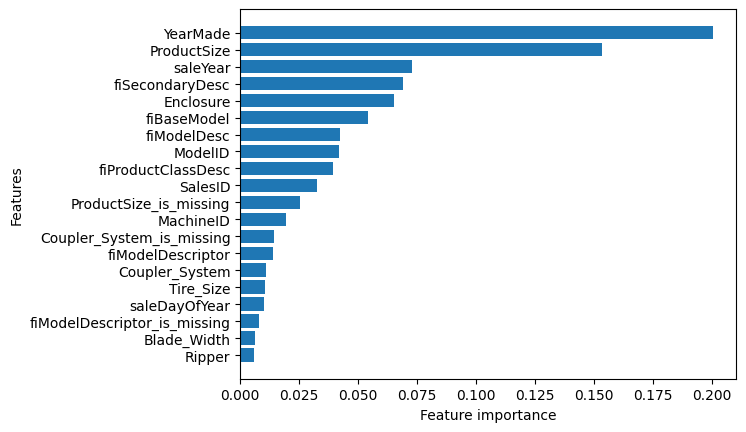

In [139]:
plot_features(X_train.columns,ideal_model.feature_importances_)

**Question to finish:** Why might knowing the feature importances of a trained machine learning model be helpful?

Knowing the feature importances of a trained machine learning model is helpful because it tells you **which input variables most influence the model’s predictions**. This information can be used to:

1. **Interpret the model** – understand why the model makes certain predictions.
2. **Feature selection** – remove unimportant features to simplify the model and reduce noise.
3. **Improve data collection** – focus on collecting or improving the most important features.
4. **Debug the model** – detect if the model is relying on irrelevant or misleading features.
5. **Communicate insights** – explain to stakeholders which factors drive outcomes.

In short, feature importances provide **transparency, efficiency, and guidance** for both model improvement and decision-making.


<hr>

**Final challenge** What other machine learning models could you try on our dataset?
Hint: https://scikit-learn.org/stable/tutorial/machine_learning_map/index.html check out the regression section of thus map, or try to look at something like CatBoost.ai or XGBoost.ai.

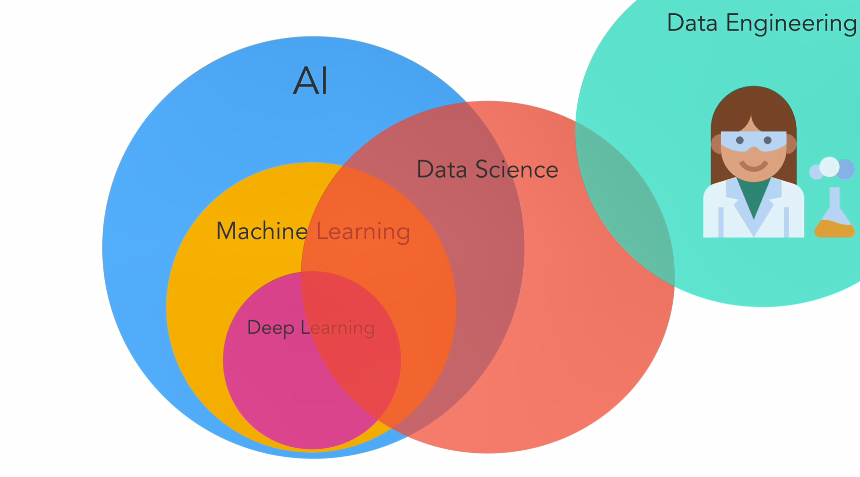

https://www.kaggle.com/datasets

You can easily load data from an SQLite database into a **pandas DataFrame** using the `sqlite3` module (built-in) together with `pandas.read_sql_query()`. Here’s how:

---

### **Step 1: Import modules**

```python
import sqlite3
import pandas as pd
```

---

### **Step 2: Connect to the SQLite database**

```python
# Replace 'my_database.db' with your SQLite file path
conn = sqlite3.connect("my_database.db")
```

---

### **Step 3: Write your SQL query**

```python
query = "SELECT * FROM my_table;"  # Replace 'my_table' with your table name
```

---

### **Step 4: Load into a pandas DataFrame**

```python
df = pd.read_sql_query(query, conn)
```

* `df` now contains the entire table (or whatever your query returns).

---

### **Step 5: Close the connection**

```python
conn.close()
```

---

### **Optional: Example with filtering**

```python
query = "SELECT id, name, age FROM my_table WHERE age > 25;"
df = pd.read_sql_query(query, conn)
```

---

✅ **Key points**

* You can use **any valid SQL query** in `read_sql_query`.
* For large databases, you can fetch data in chunks using the `chunksize` parameter.

---

If you want, I can also show a **way to read all tables from an SQLite DB into separate DataFrames automatically**. Do you want me to show that?


Here’s a way to **read all tables from an SQLite database into separate pandas DataFrames automatically**:

---

### **Step 1: Import modules and connect**

```python
import sqlite3
import pandas as pd

conn = sqlite3.connect("my_database.db")  # Replace with your DB file
```

---

### **Step 2: Get all table names**

```python
query_tables = "SELECT name FROM sqlite_master WHERE type='table';"
tables = pd.read_sql_query(query_tables, conn)
table_names = tables['name'].tolist()
```

---

### **Step 3: Read each table into a DataFrame**

```python
dfs = {}  # Dictionary to store DataFrames

for table in table_names:
    dfs[table] = pd.read_sql_query(f"SELECT * FROM {table};", conn)
```

* Now `dfs` is a dictionary:

  * Keys = table names
  * Values = DataFrames for each table

```python
# Example: access the DataFrame for table 'users'
df_users = dfs['users']
print(df_users.head())
```

---

### **Step 4: Close the connection**

```python
conn.close()
```

---

✅ **Advantages**:

* Automatically handles all tables in the database.
* You can loop over `dfs` to process multiple tables easily.

---

If you want, I can show an **even shorter one-liner using a dictionary comprehension** that does the same thing in fewer lines. Do you want me to do that?


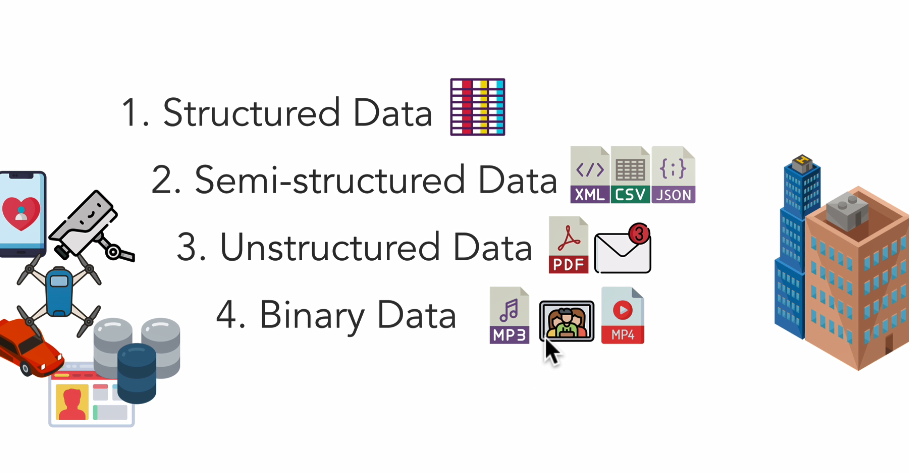

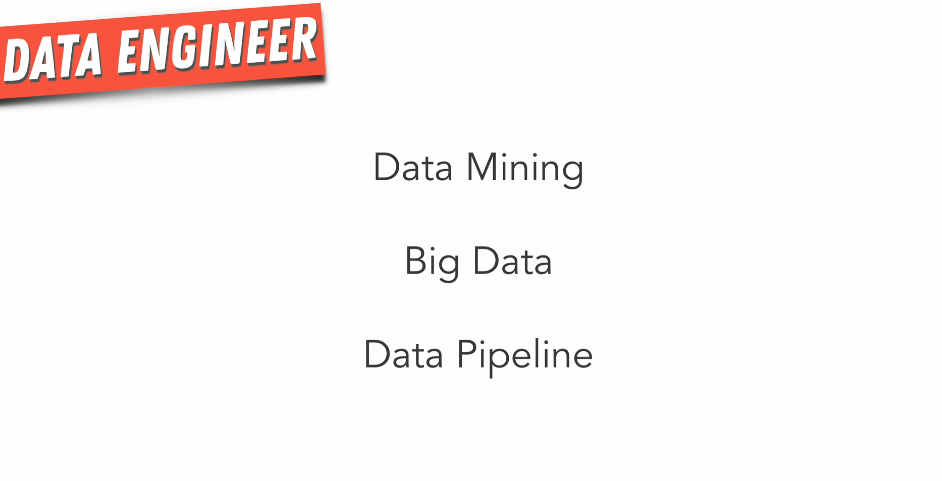

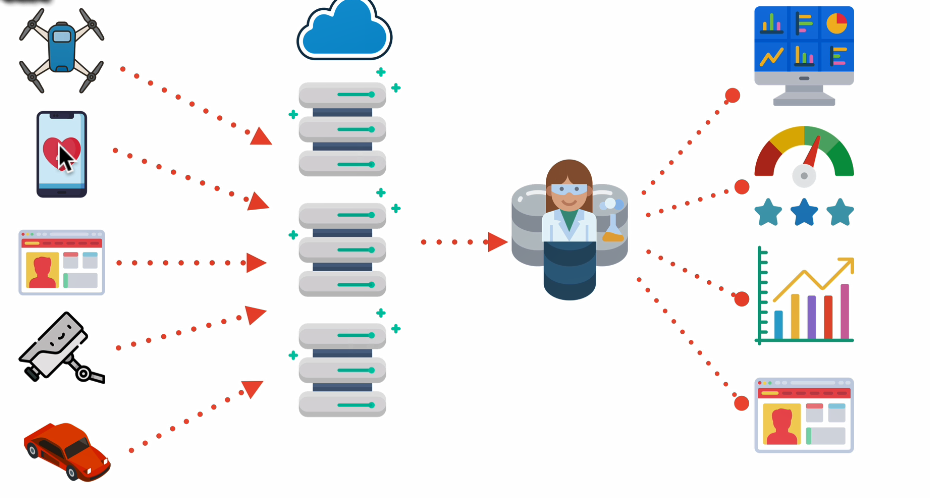

# Data Collecting

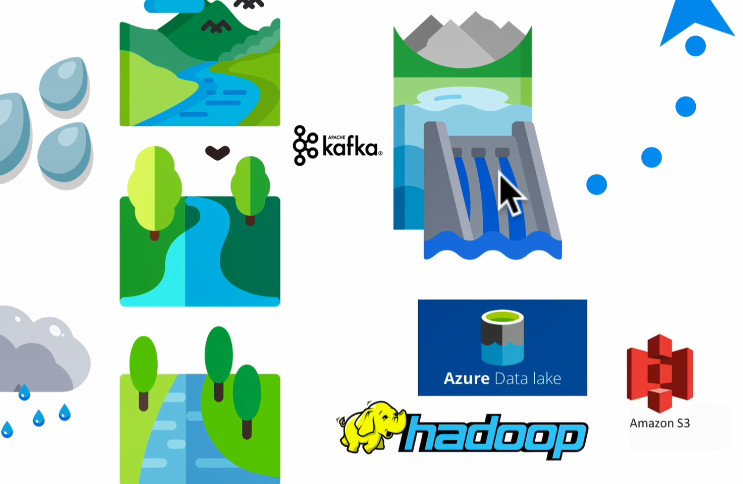

# Data warehouse

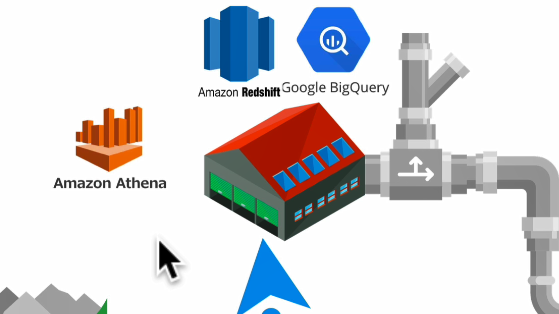

machine learning engineer usually work with data lake because more data means more inputs to provide to model (better) we can use structured or unstructured data

data warehouse is usually for data analysts, bis , business analysts etc we ml engineer can also use data warehouse

data engineer do:
* build etl (extract transport load) pipeline
* building analysis tools
* maintain data-warehouses and data lakes

https://blog.yugabyte.com/a-primer-on-acid-transactions/

https://techdifferences.com/difference-between-oltp-and-olap.html

# Types of databases that exists

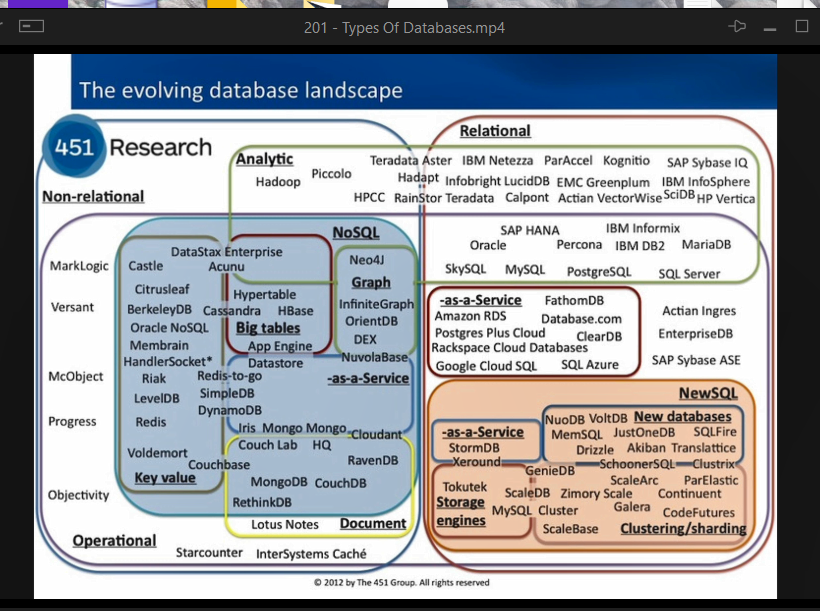

# 3 main category of databases

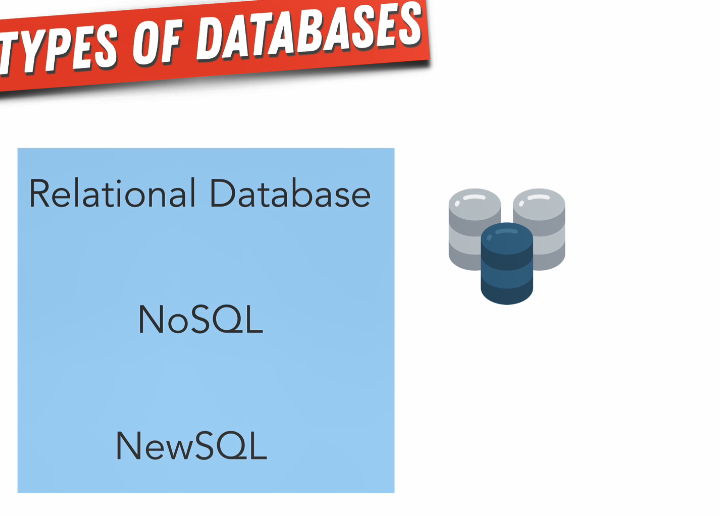

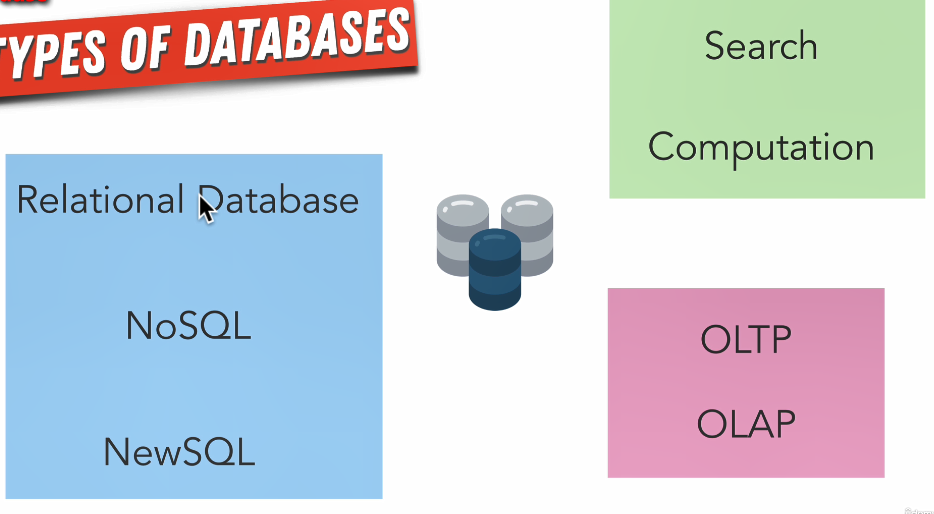

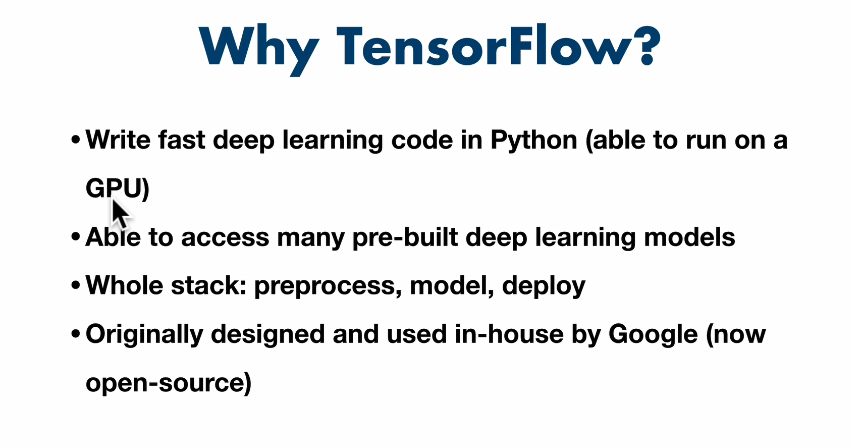

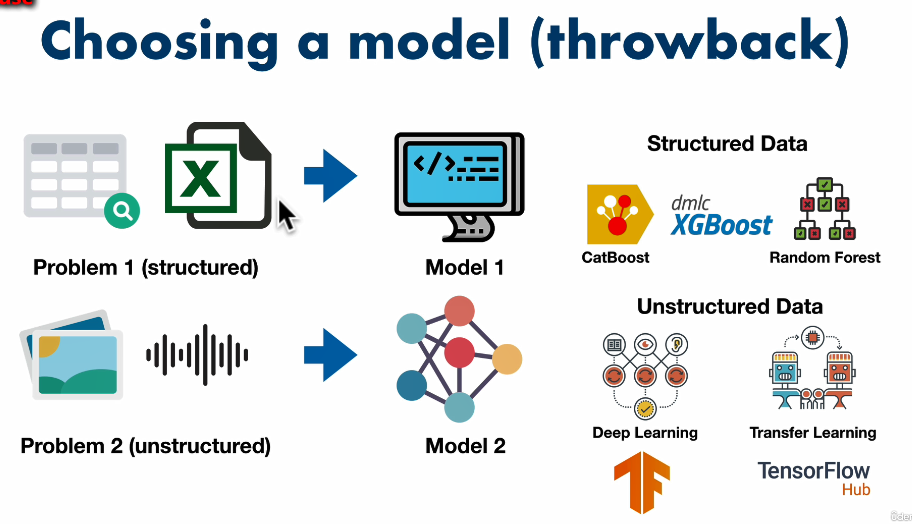

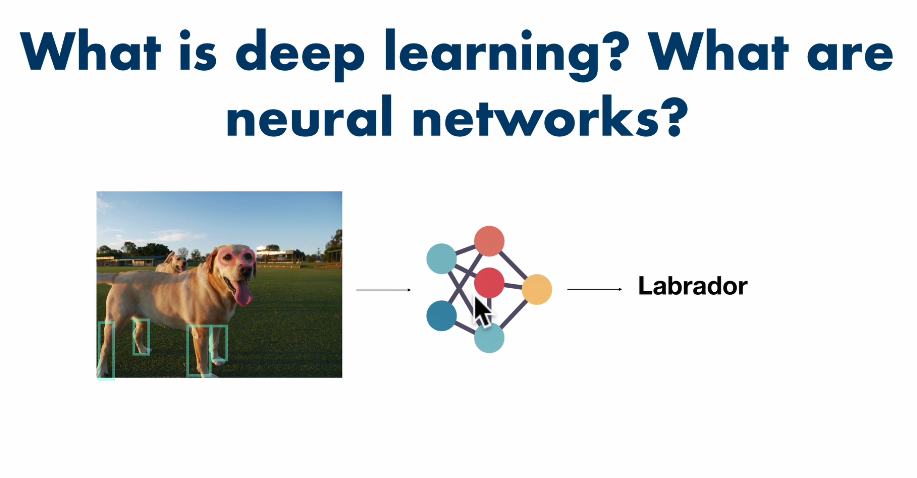

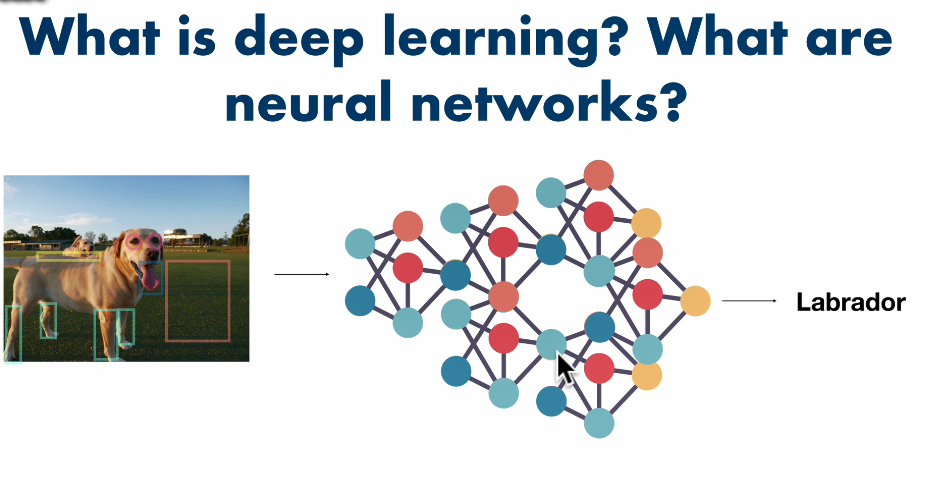

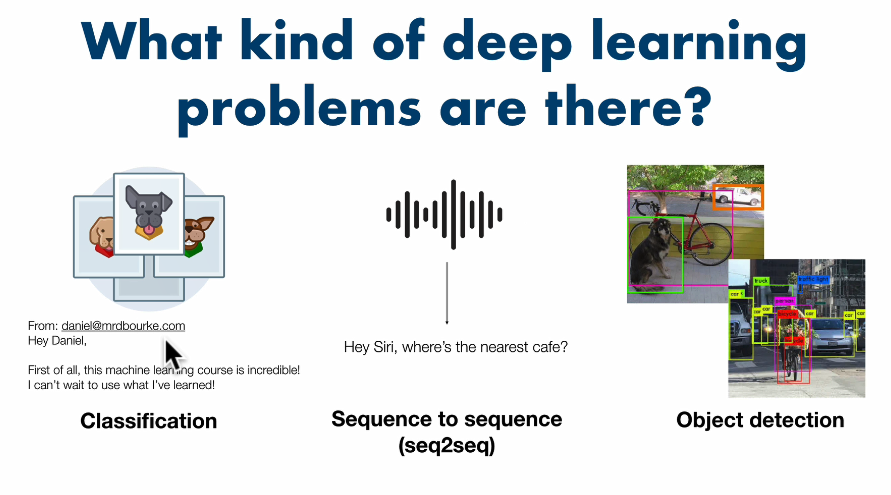

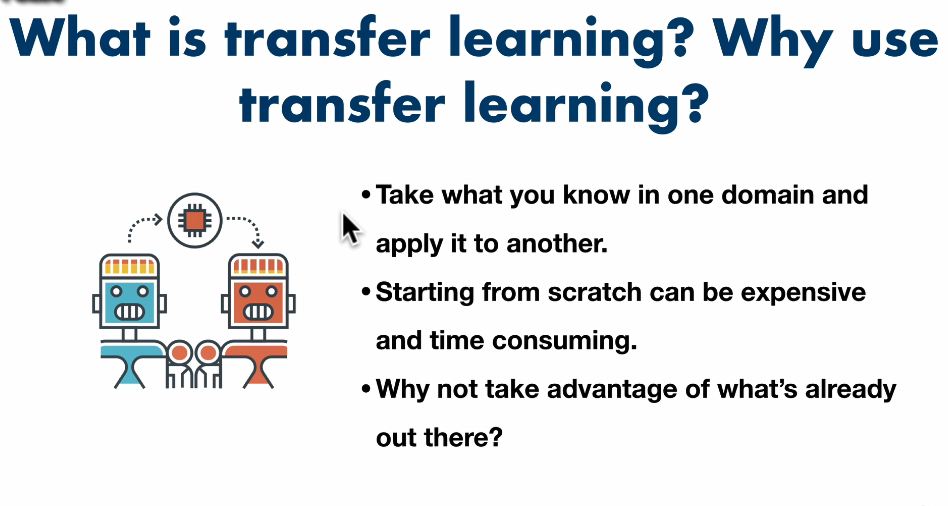

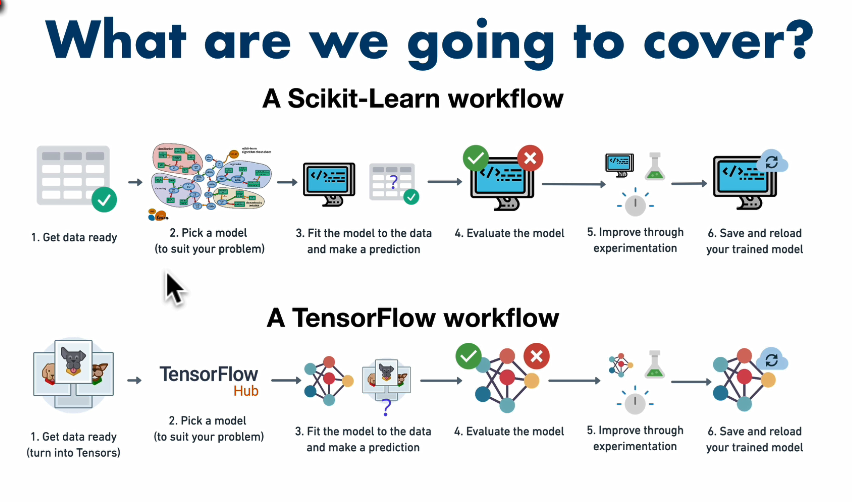

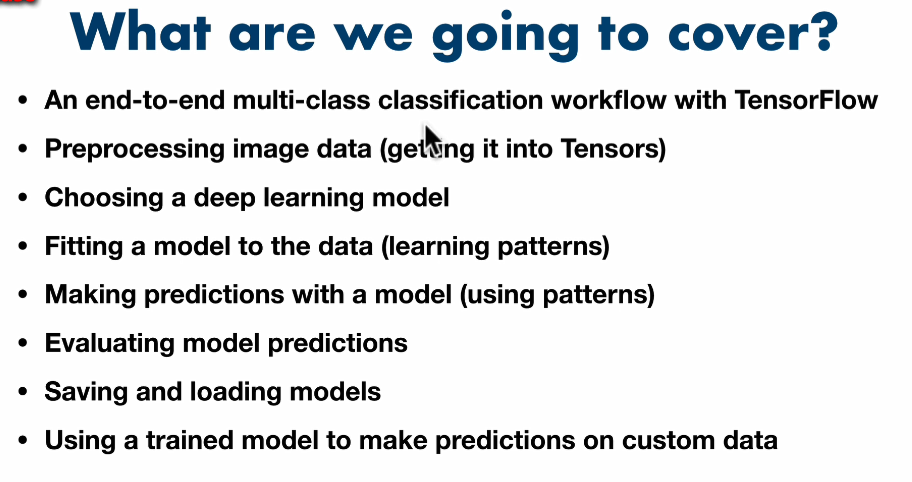

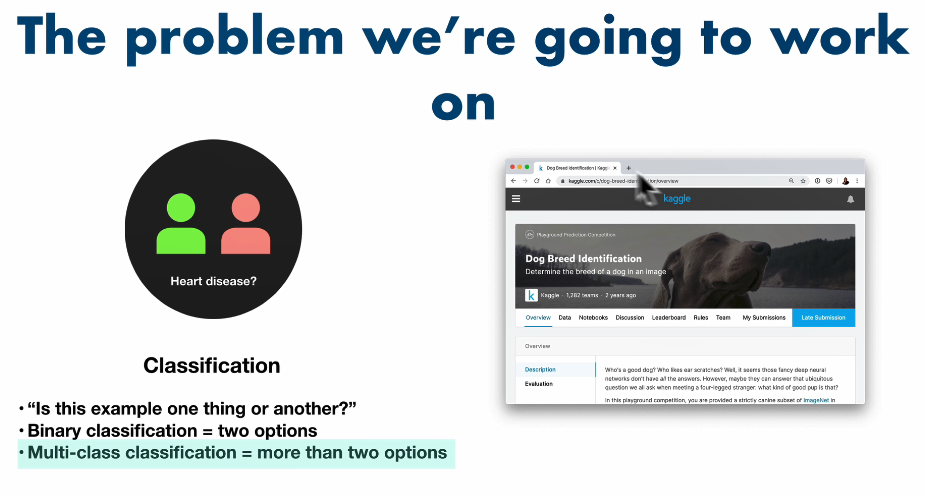

https://github.com/mrdbourke/zero-to-mastery-ml/blob/wip/section-4-unstructured-data-projects/end-to-end-dog-vision.ipynb

https://colab.research.google.com/notebooks/io.ipynb

https://colab.research.google.com/

https://colab.research.google.com/notebooks/intro.ipynb

https://www.kaggle.com/c/dog-breed-identification/overview

https://research.google.com/colaboratory/faq.html

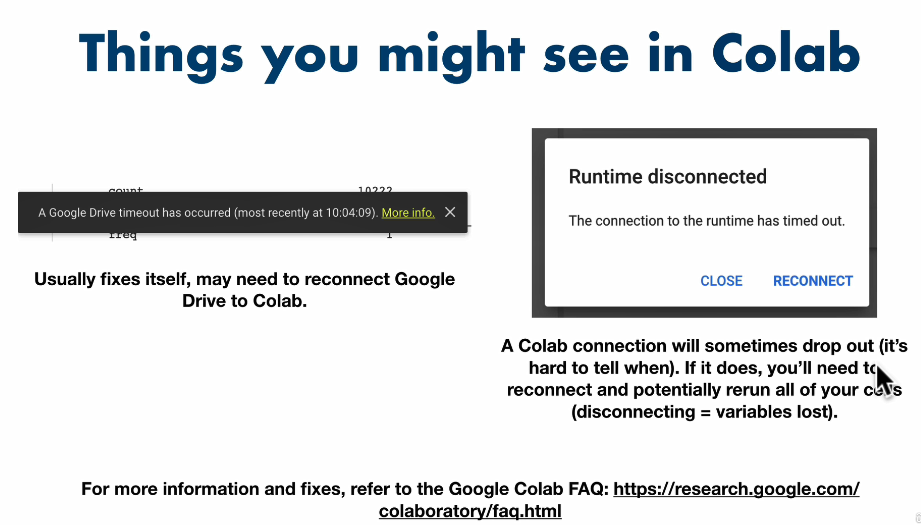